# Importando los modulos necesarios

In [19]:
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gseapy as gp
from gseapy import dotplot


plt.rcParams['figure.dpi'] = 300
plt.style.use('ggplot')

sns.set(style='ticks',
        palette='muted',
        context='notebook')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Importando la data

In [2]:
beta_matrix = pd.read_table('../data/hg19_beta.matrix.gz')
annot_file = pd.read_table('../data/hg19_segmented.annot.bed.gz', header=None)

Aqui cambiamos el nombre de las columnas para despues usarlo con facilidad


In [3]:
annot_file.columns = ['chr', 'start', 'end', 'startCpG', 'endCpG', 'type', 'gene']

## Breve inspeccion de la data

Con este comando estamos encontrando las filas que no tienen la data completa.


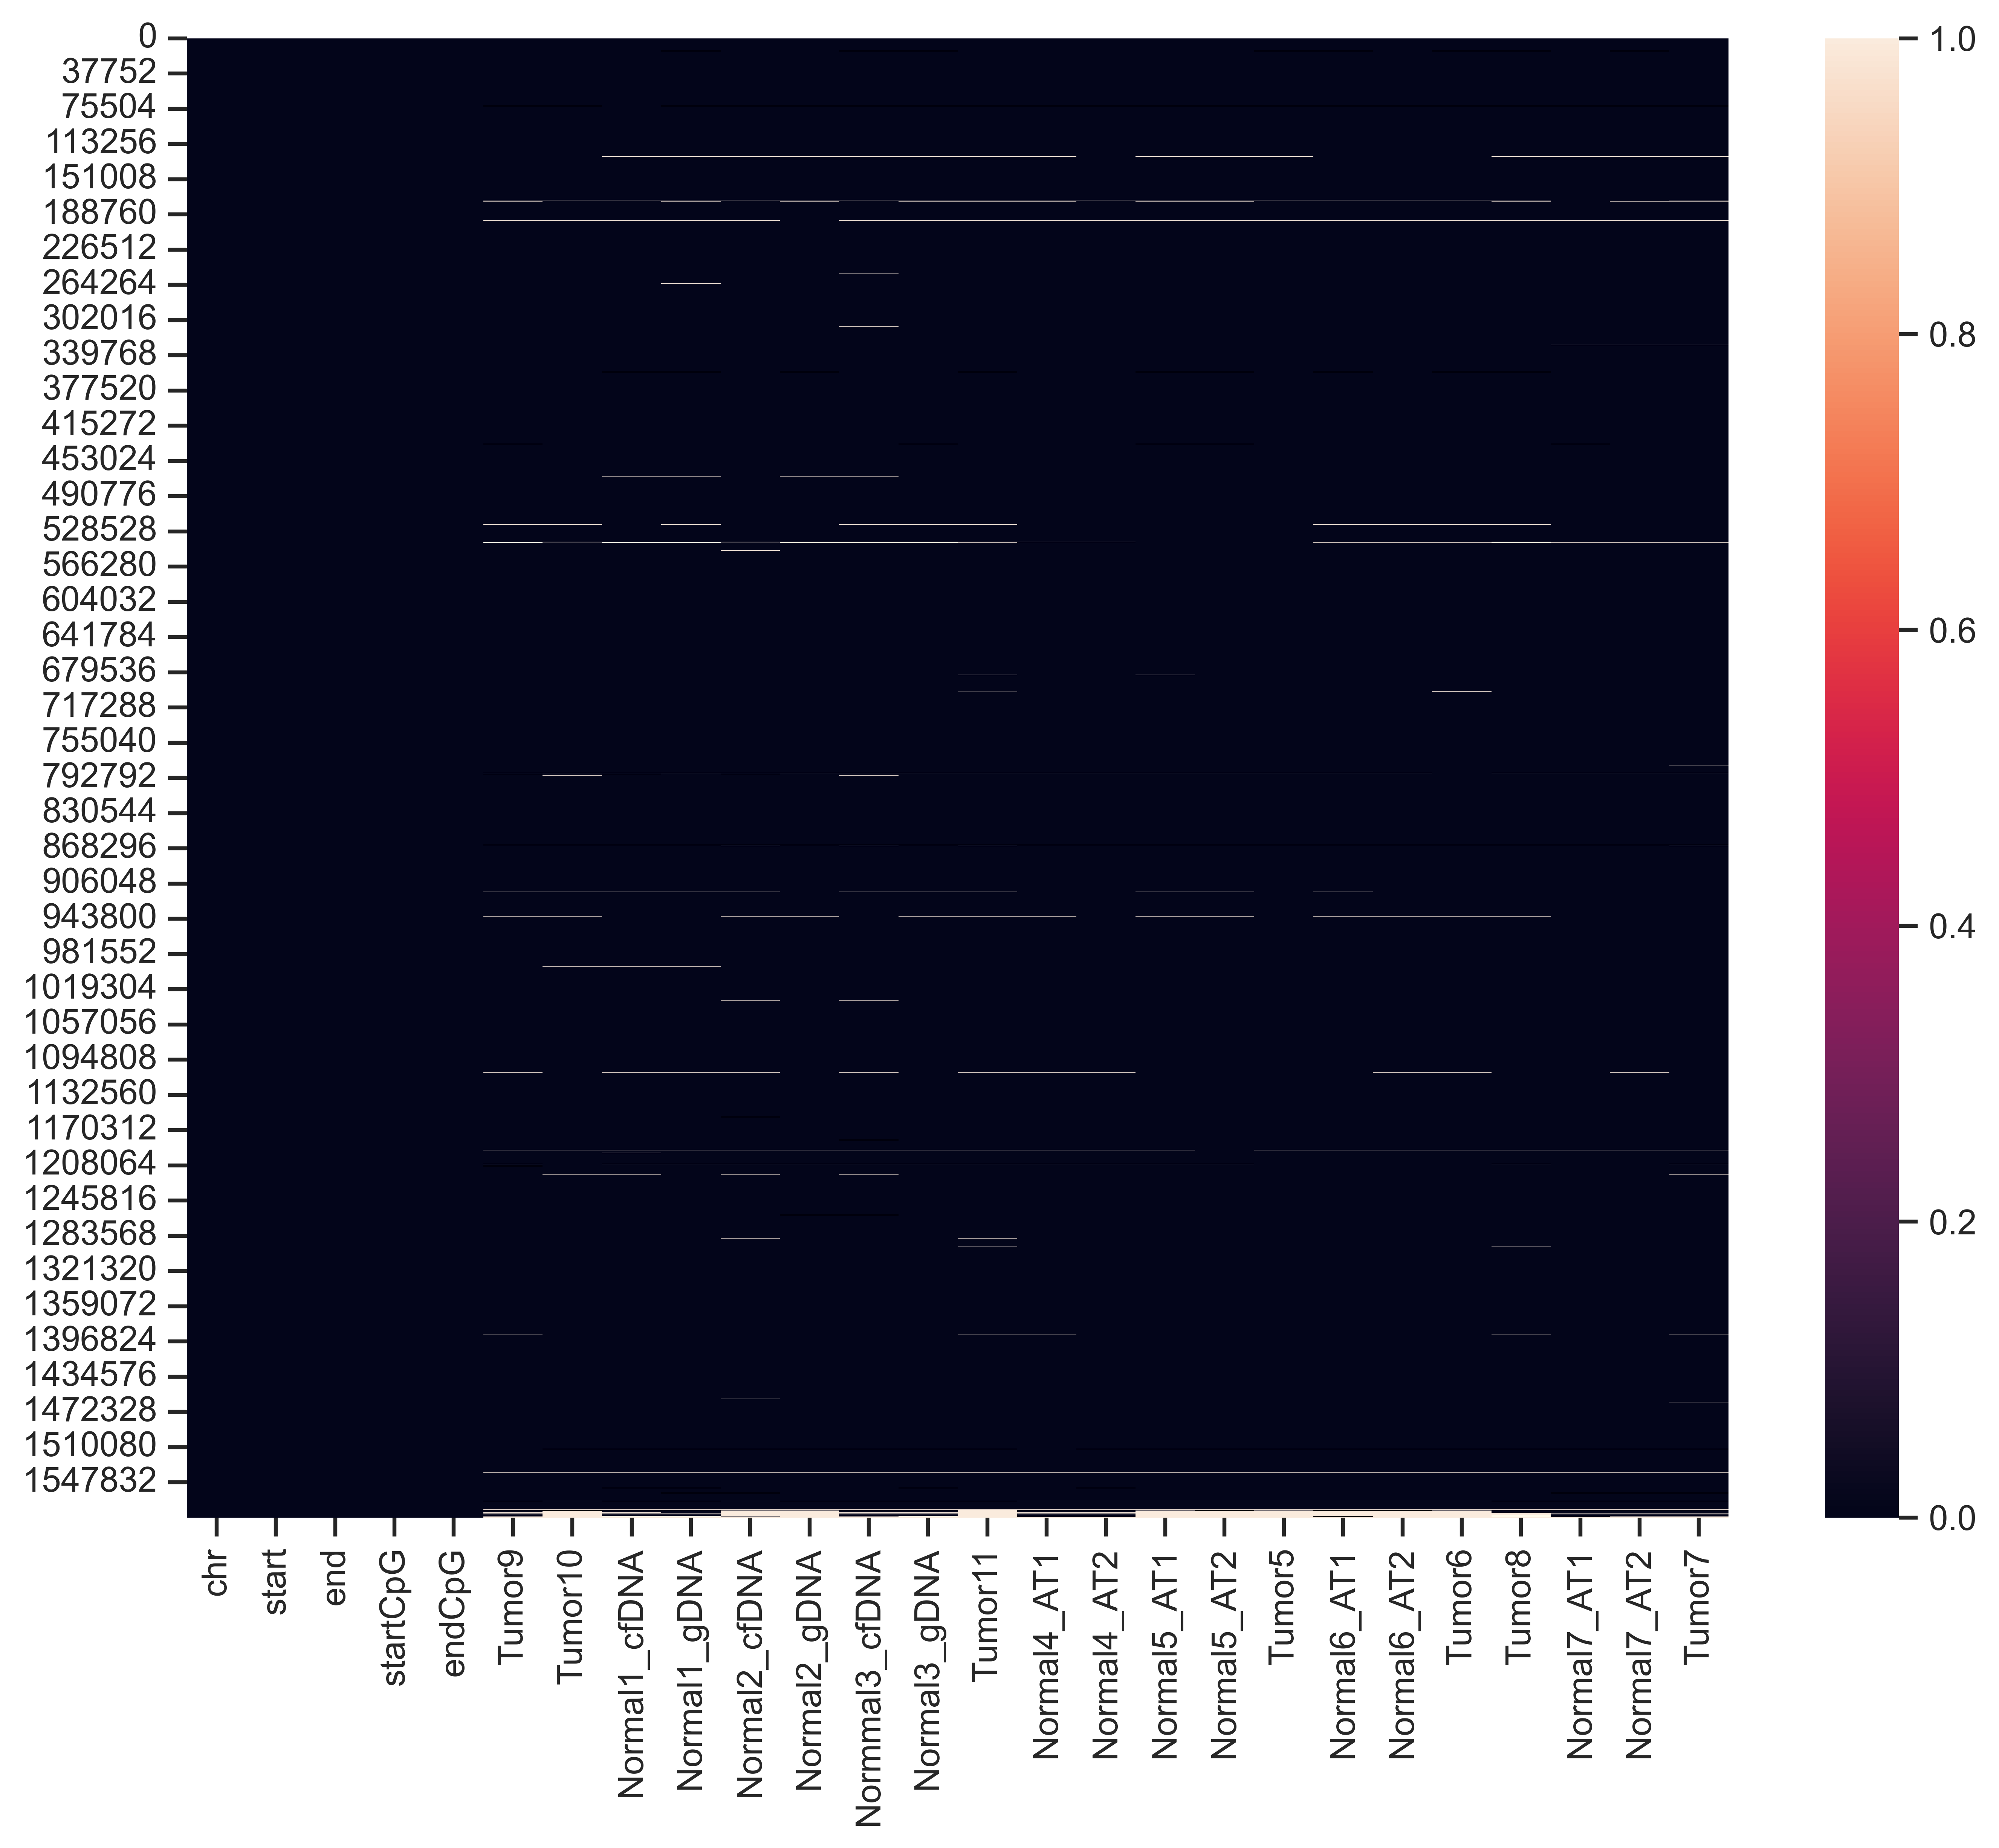

In [4]:
plt.figure(figsize=(11, 8.5))

sns.heatmap(beta_matrix.isna(), vmin = 0, vmax = 1)
plt.show()

Con este comando estamos llenando las filas con data incompleta

In [5]:
beta_matrix.fillna(0.5, inplace=True)

Y volvemos a verificar que ya no hay filas incompletas

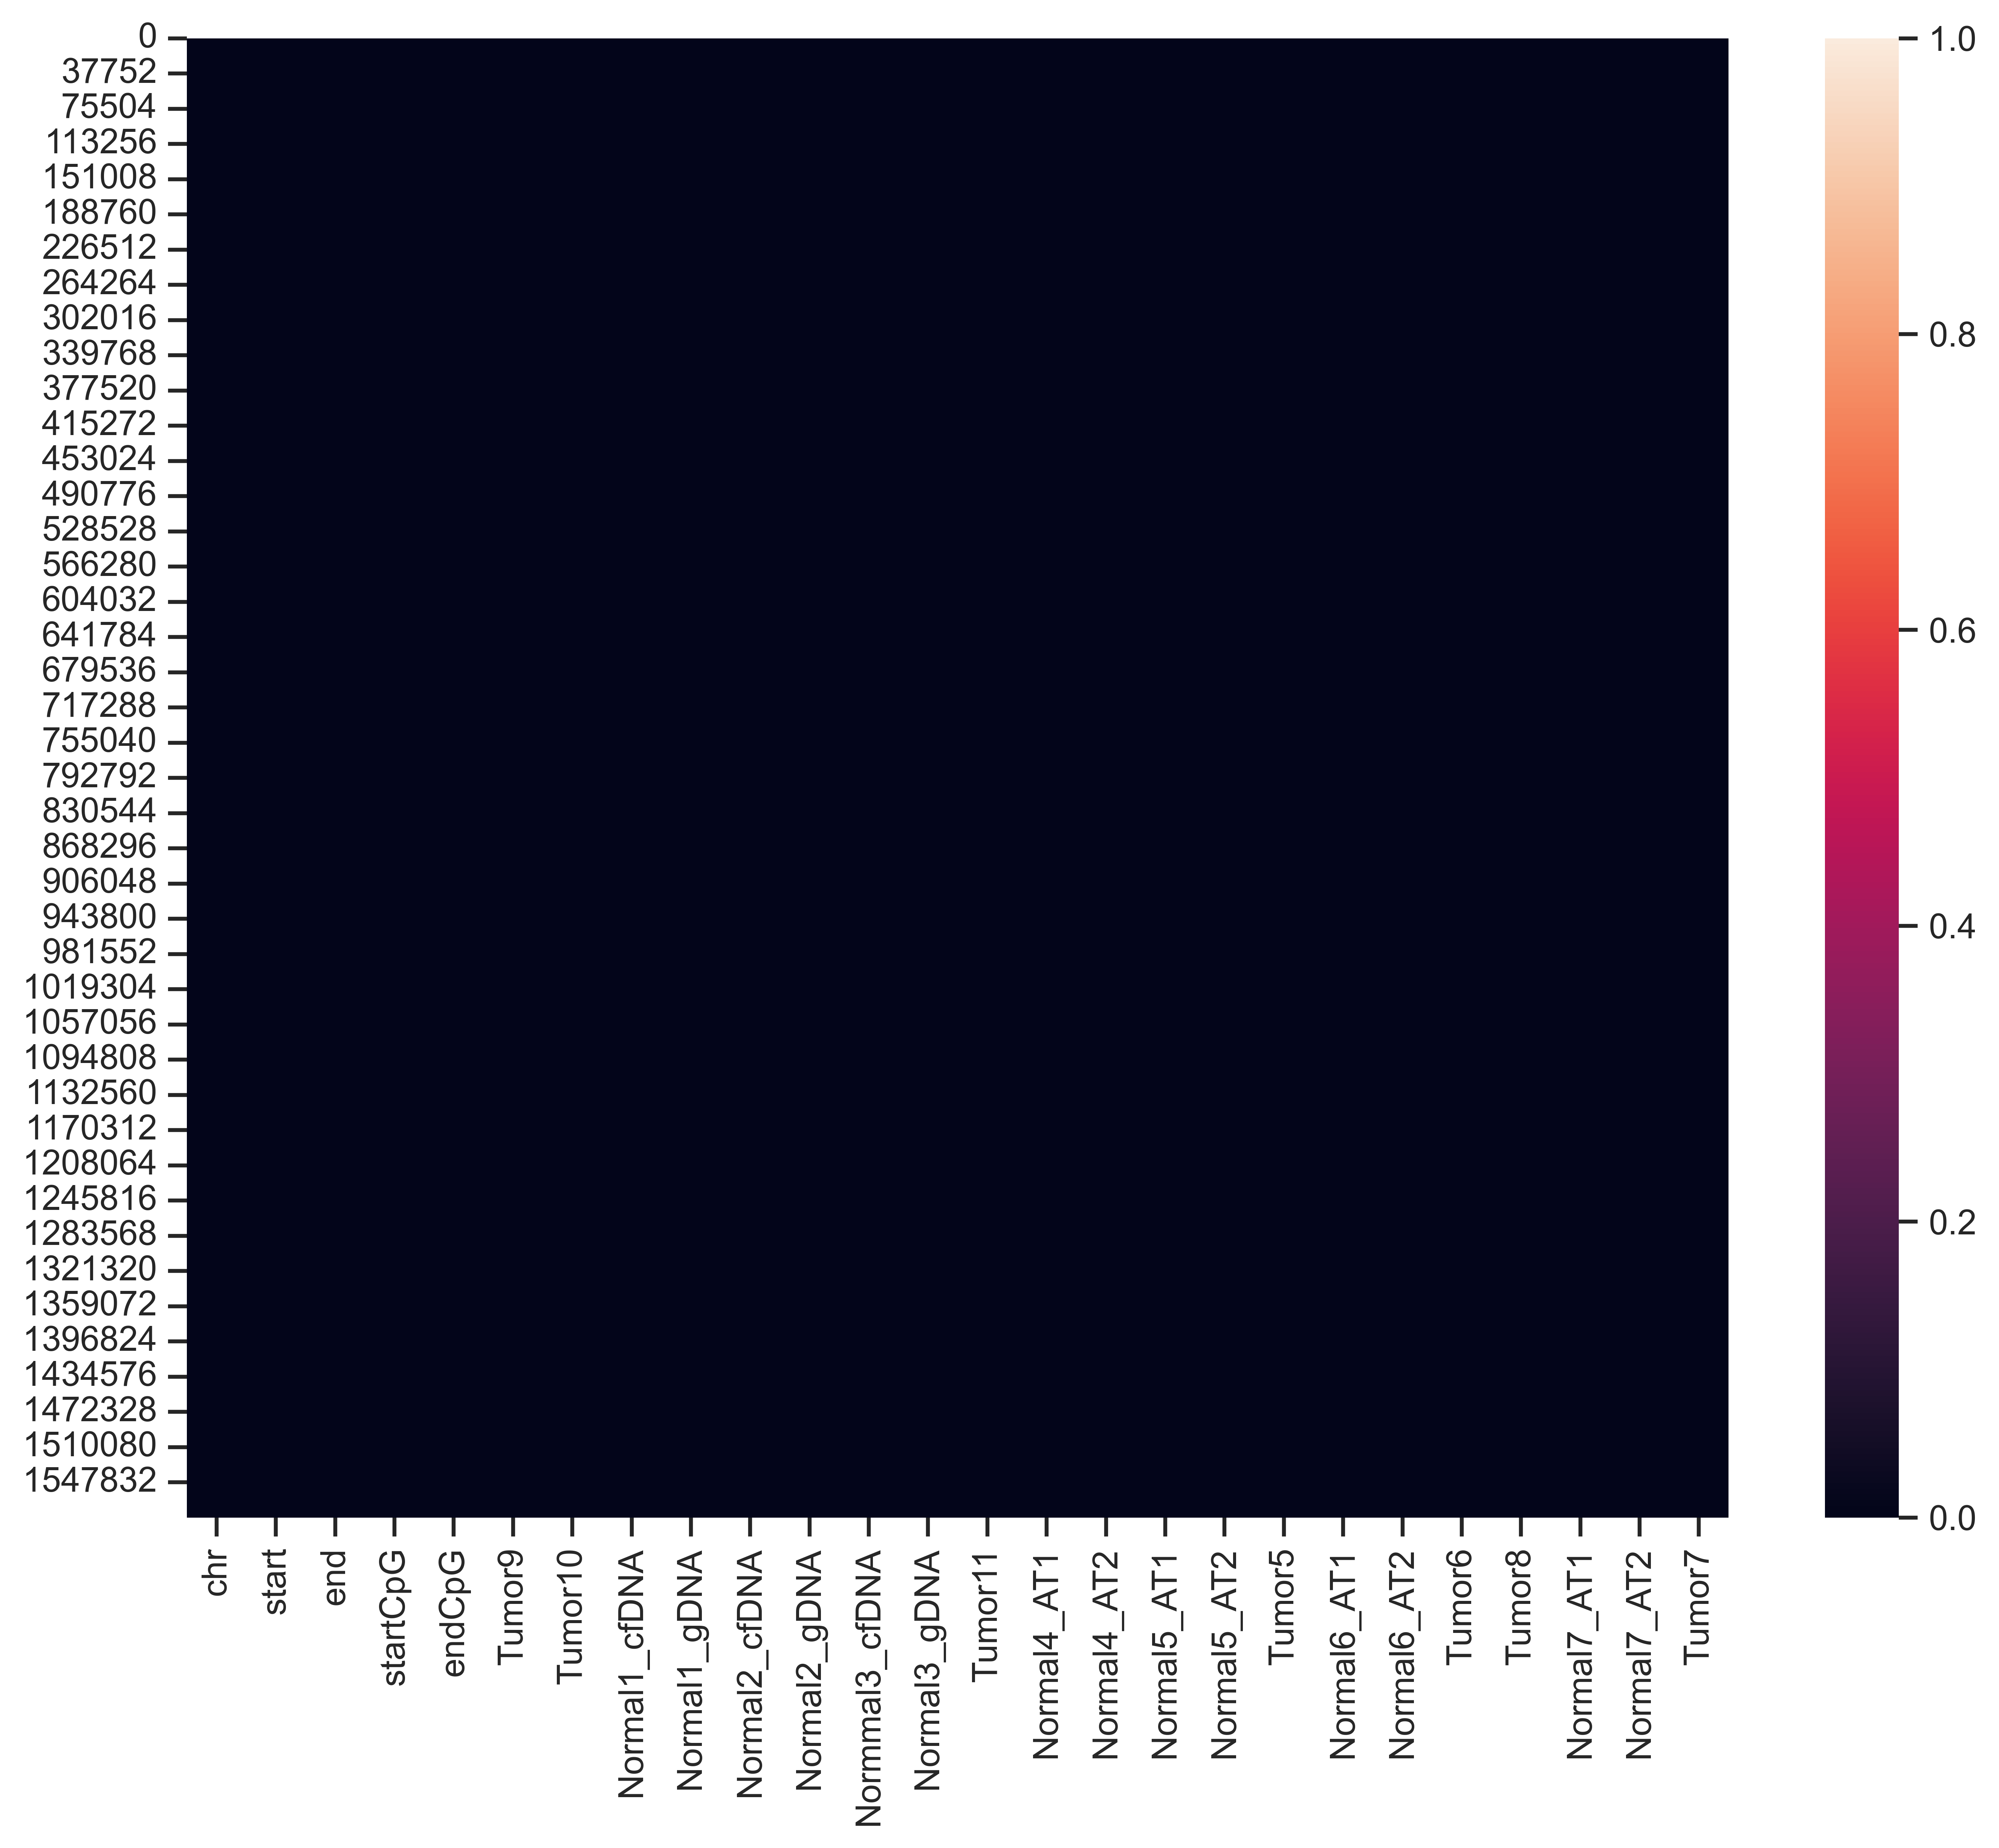

In [6]:
plt.figure(figsize=(11, 8.5))

sns.heatmap(beta_matrix.isna(), vmin = 0, vmax = 1)
plt.show()

# Identificacion de las regiones differentes entre tumor y normal 

Identificar las muestras normales y de tumores

In [7]:
normal_matrix = beta_matrix.loc[: , beta_matrix.columns.str.contains('Normal')]
tumor_matrix = beta_matrix.loc[: , beta_matrix.columns.str.contains('Tumor')]

Encontrar la diferencia promedia entre los grupos

In [8]:
differencia_promedia = np.mean(tumor_matrix, axis = 1) - np.mean(normal_matrix, axis = 1)

Encontar cual de las regiones son significamente differentes usando estadistica

In [9]:
stat, p = sp.stats.mannwhitneyu(tumor_matrix, normal_matrix, axis = 1)

In [10]:
qval = sp.stats.false_discovery_control(p)

Añadir los resultados al `annot_file` para filtrar por las regiones importantes

In [11]:
annot_file['diff_tumor_normal'] = differencia_promedia
annot_file['qval'] = qval

## Regiones diferentes entre tumor vs. normal

Filtrar por las regiones (filas) que son significantemente differentes entre tumor vs. normal

In [12]:
reg_sig = annot_file[(annot_file['qval'] <= 0.05) & (np.abs(annot_file['diff_tumor_normal']) > 0.50)]

/Users/dalmanza/anaconda3/envs/CdeC_Peru/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/dalmanza/anaconda3/envs/CdeC_Peru/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 3300x2550 with 0 Axes>

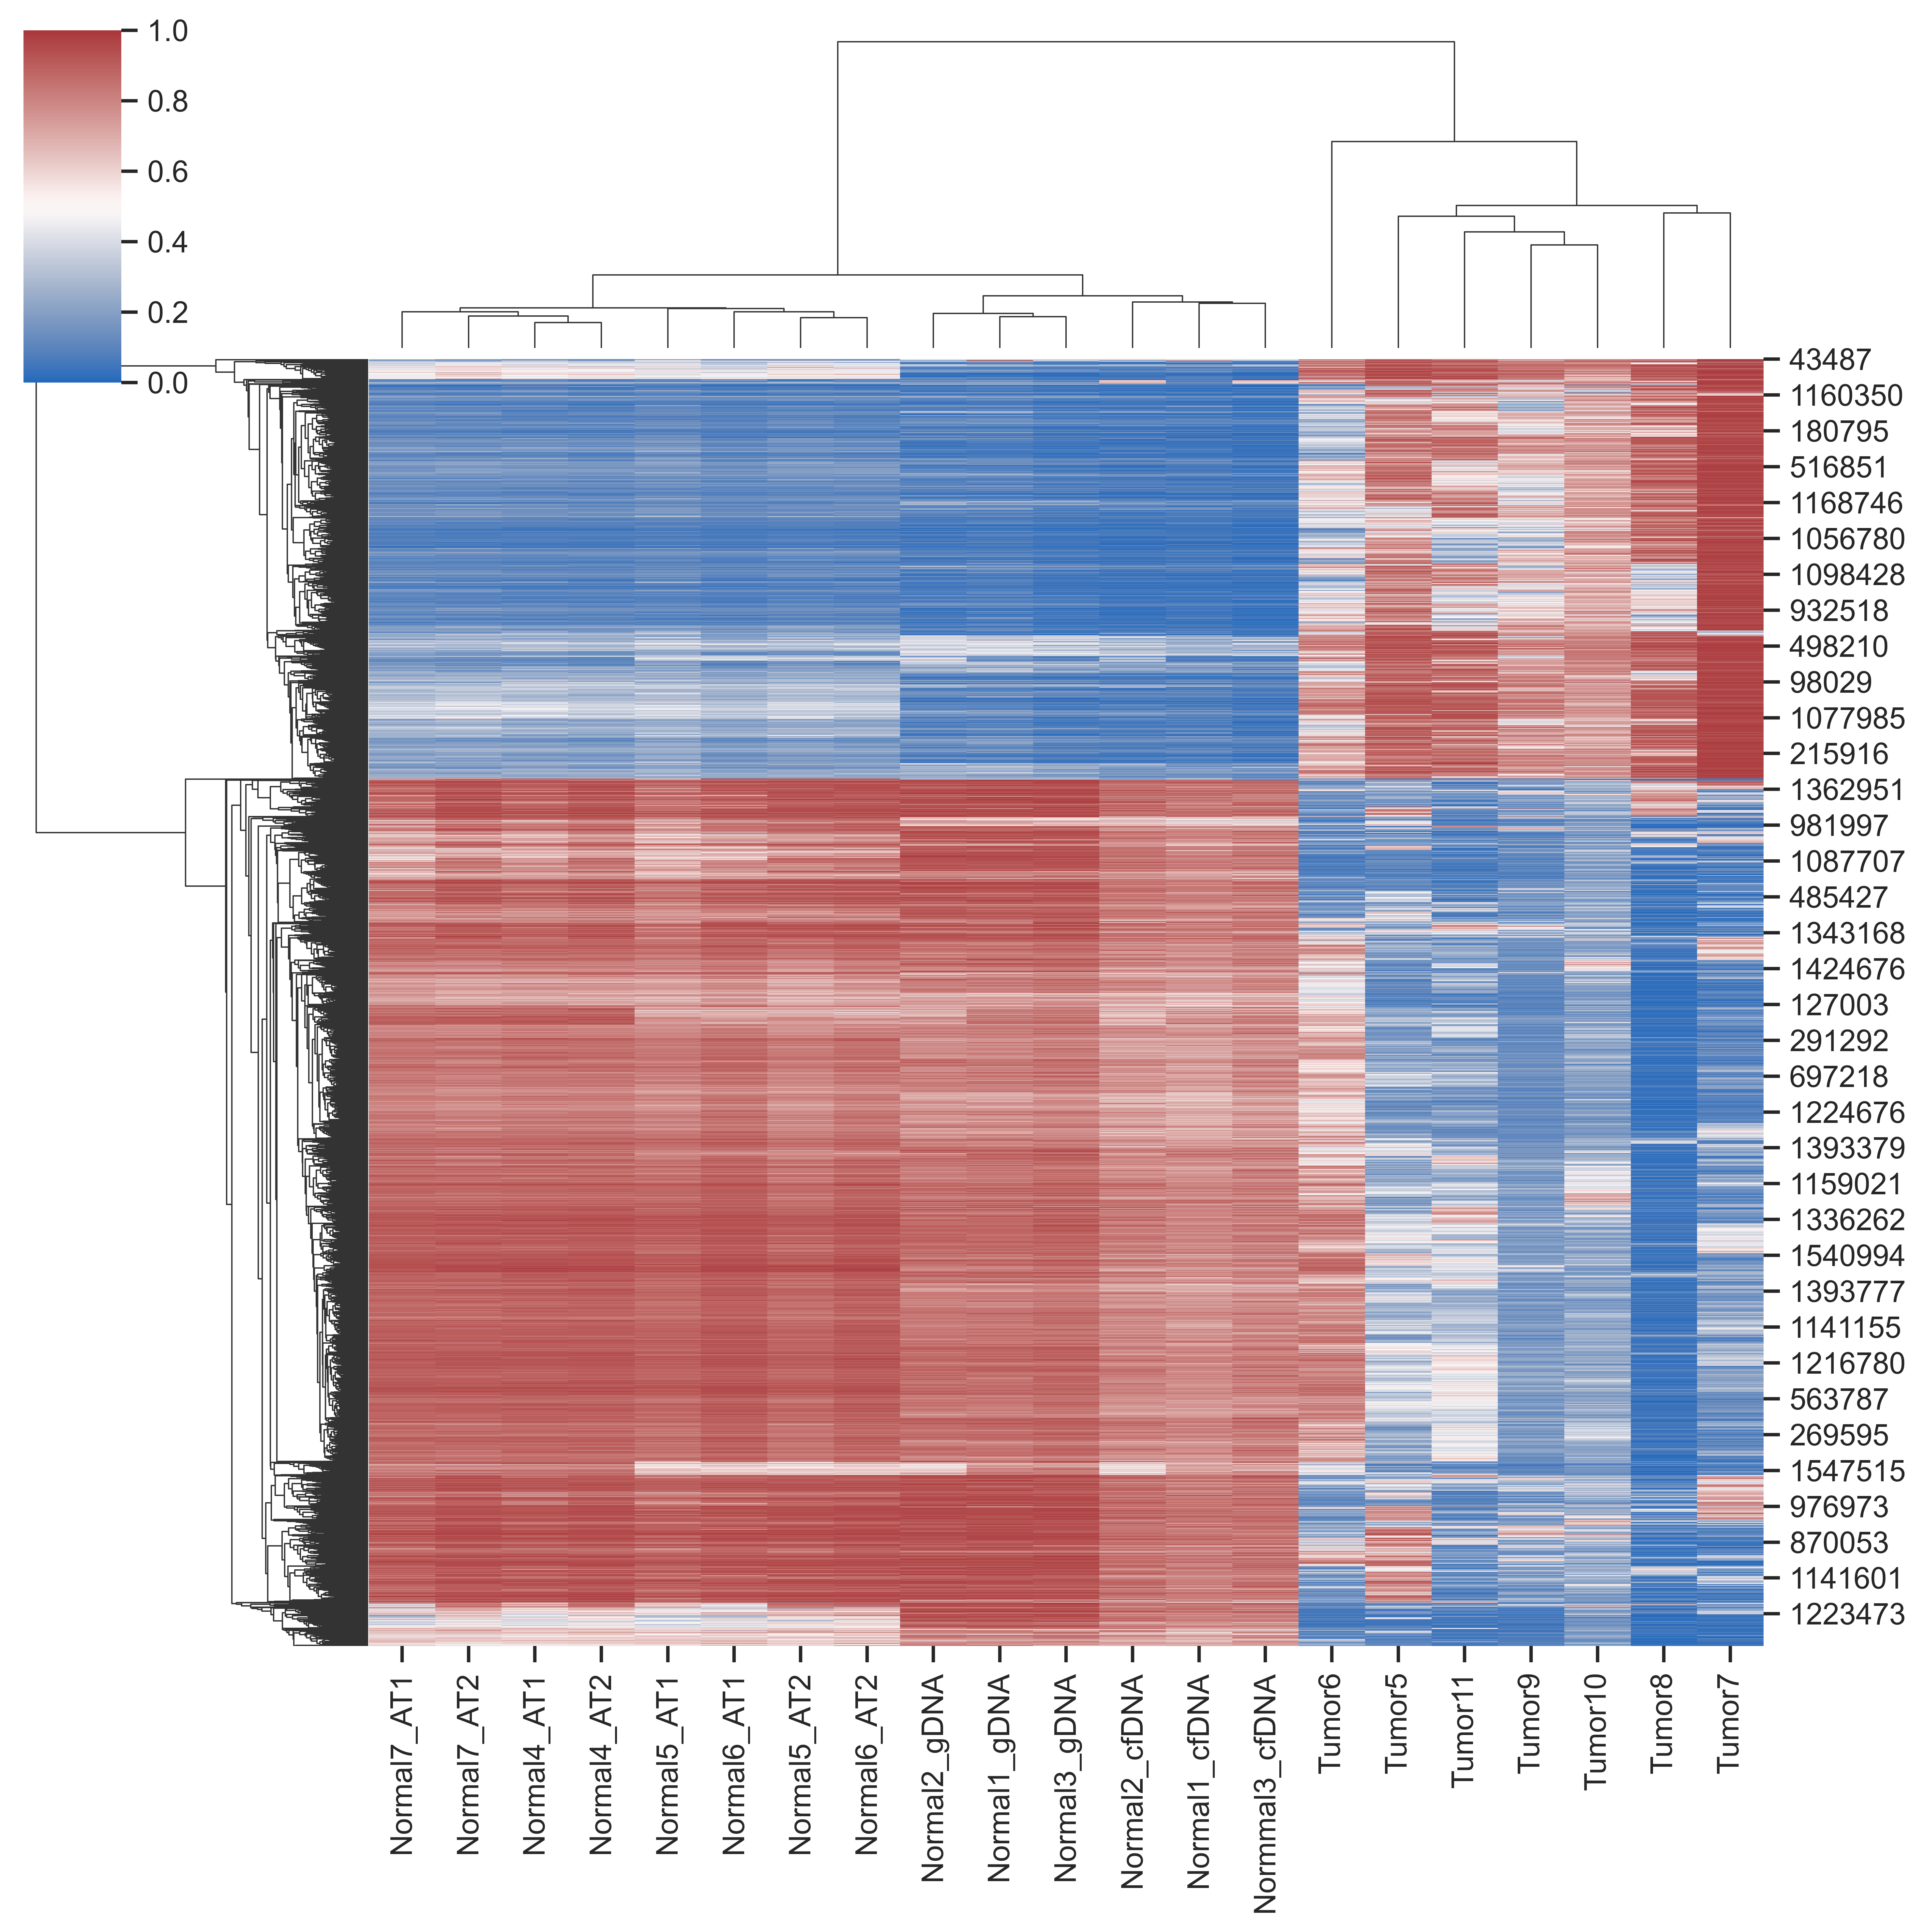

In [14]:
plt.figure(figsize=(11, 8.5))

sns.clustermap(
    beta_matrix.iloc[reg_sig.index, 5::],
    cmap = 'vlag',
    center = 0.5
)
plt.show()

### Regiones de hipermetilacion

In [15]:
reg_sig_hyper = annot_file[(annot_file['qval'] <= 0.05) & (annot_file['diff_tumor_normal'] >= 0.50)]

/Users/dalmanza/anaconda3/envs/CdeC_Peru/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/dalmanza/anaconda3/envs/CdeC_Peru/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 3300x2550 with 0 Axes>

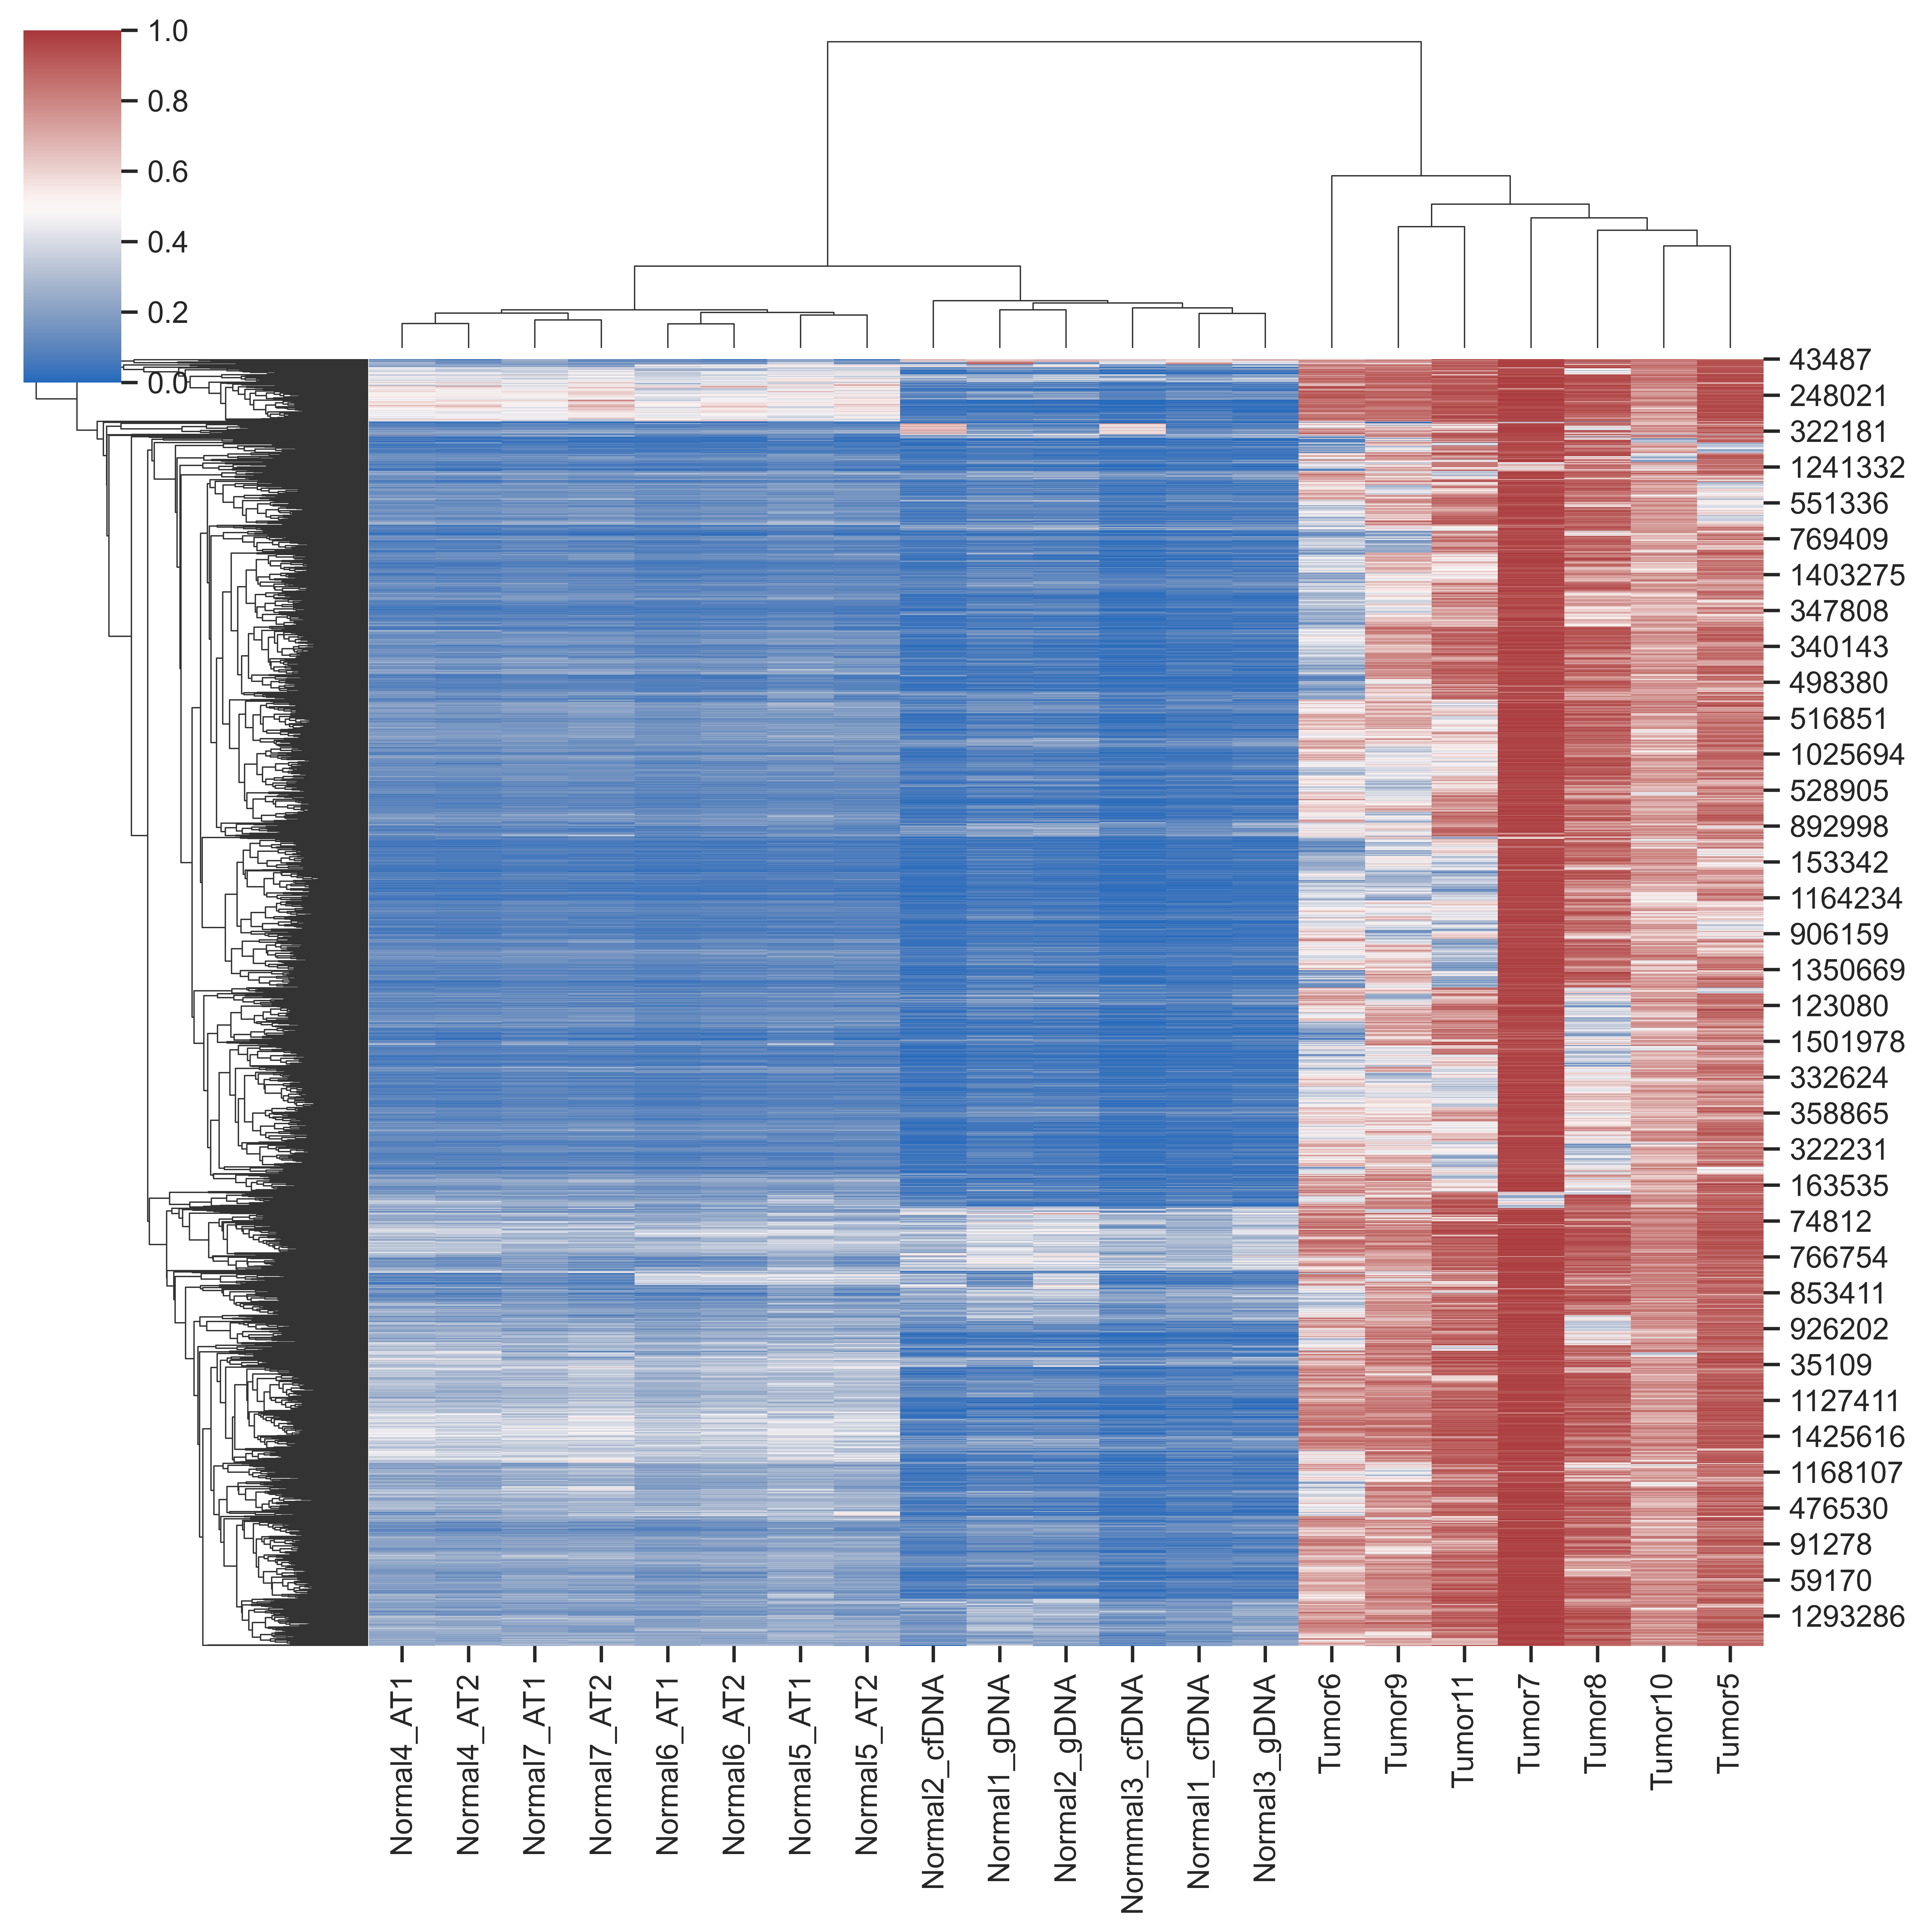

In [16]:
plt.figure(figsize=(11, 8.5))

sns.clustermap(
    beta_matrix.iloc[reg_sig_hyper.index, 5::],
    cmap = 'vlag',
    center = 0.5
)
plt.show()

In [27]:
enr = gp.enrichr(gene_list=list(set(reg_sig_hyper['gene'])),
                 gene_sets=['GO_Biological_Process_2021', 'MSigDB_Oncogenic_Signatures','KEGG_2021_Human'],
                 organism='human',
                 outdir=None,
                )

# categorical scatterplot
ax = dotplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(11,8.5),
              title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )

/Users/dalmanza/anaconda3/envs/CdeC_Peru/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


### Regiones de hipometilacion

In [21]:
reg_sig_hipo = annot_file[(annot_file['qval'] <= 0.05) & (annot_file['diff_tumor_normal'] <= -0.50)]

/Users/dalmanza/anaconda3/envs/CdeC_Peru/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/dalmanza/anaconda3/envs/CdeC_Peru/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 3300x2550 with 0 Axes>

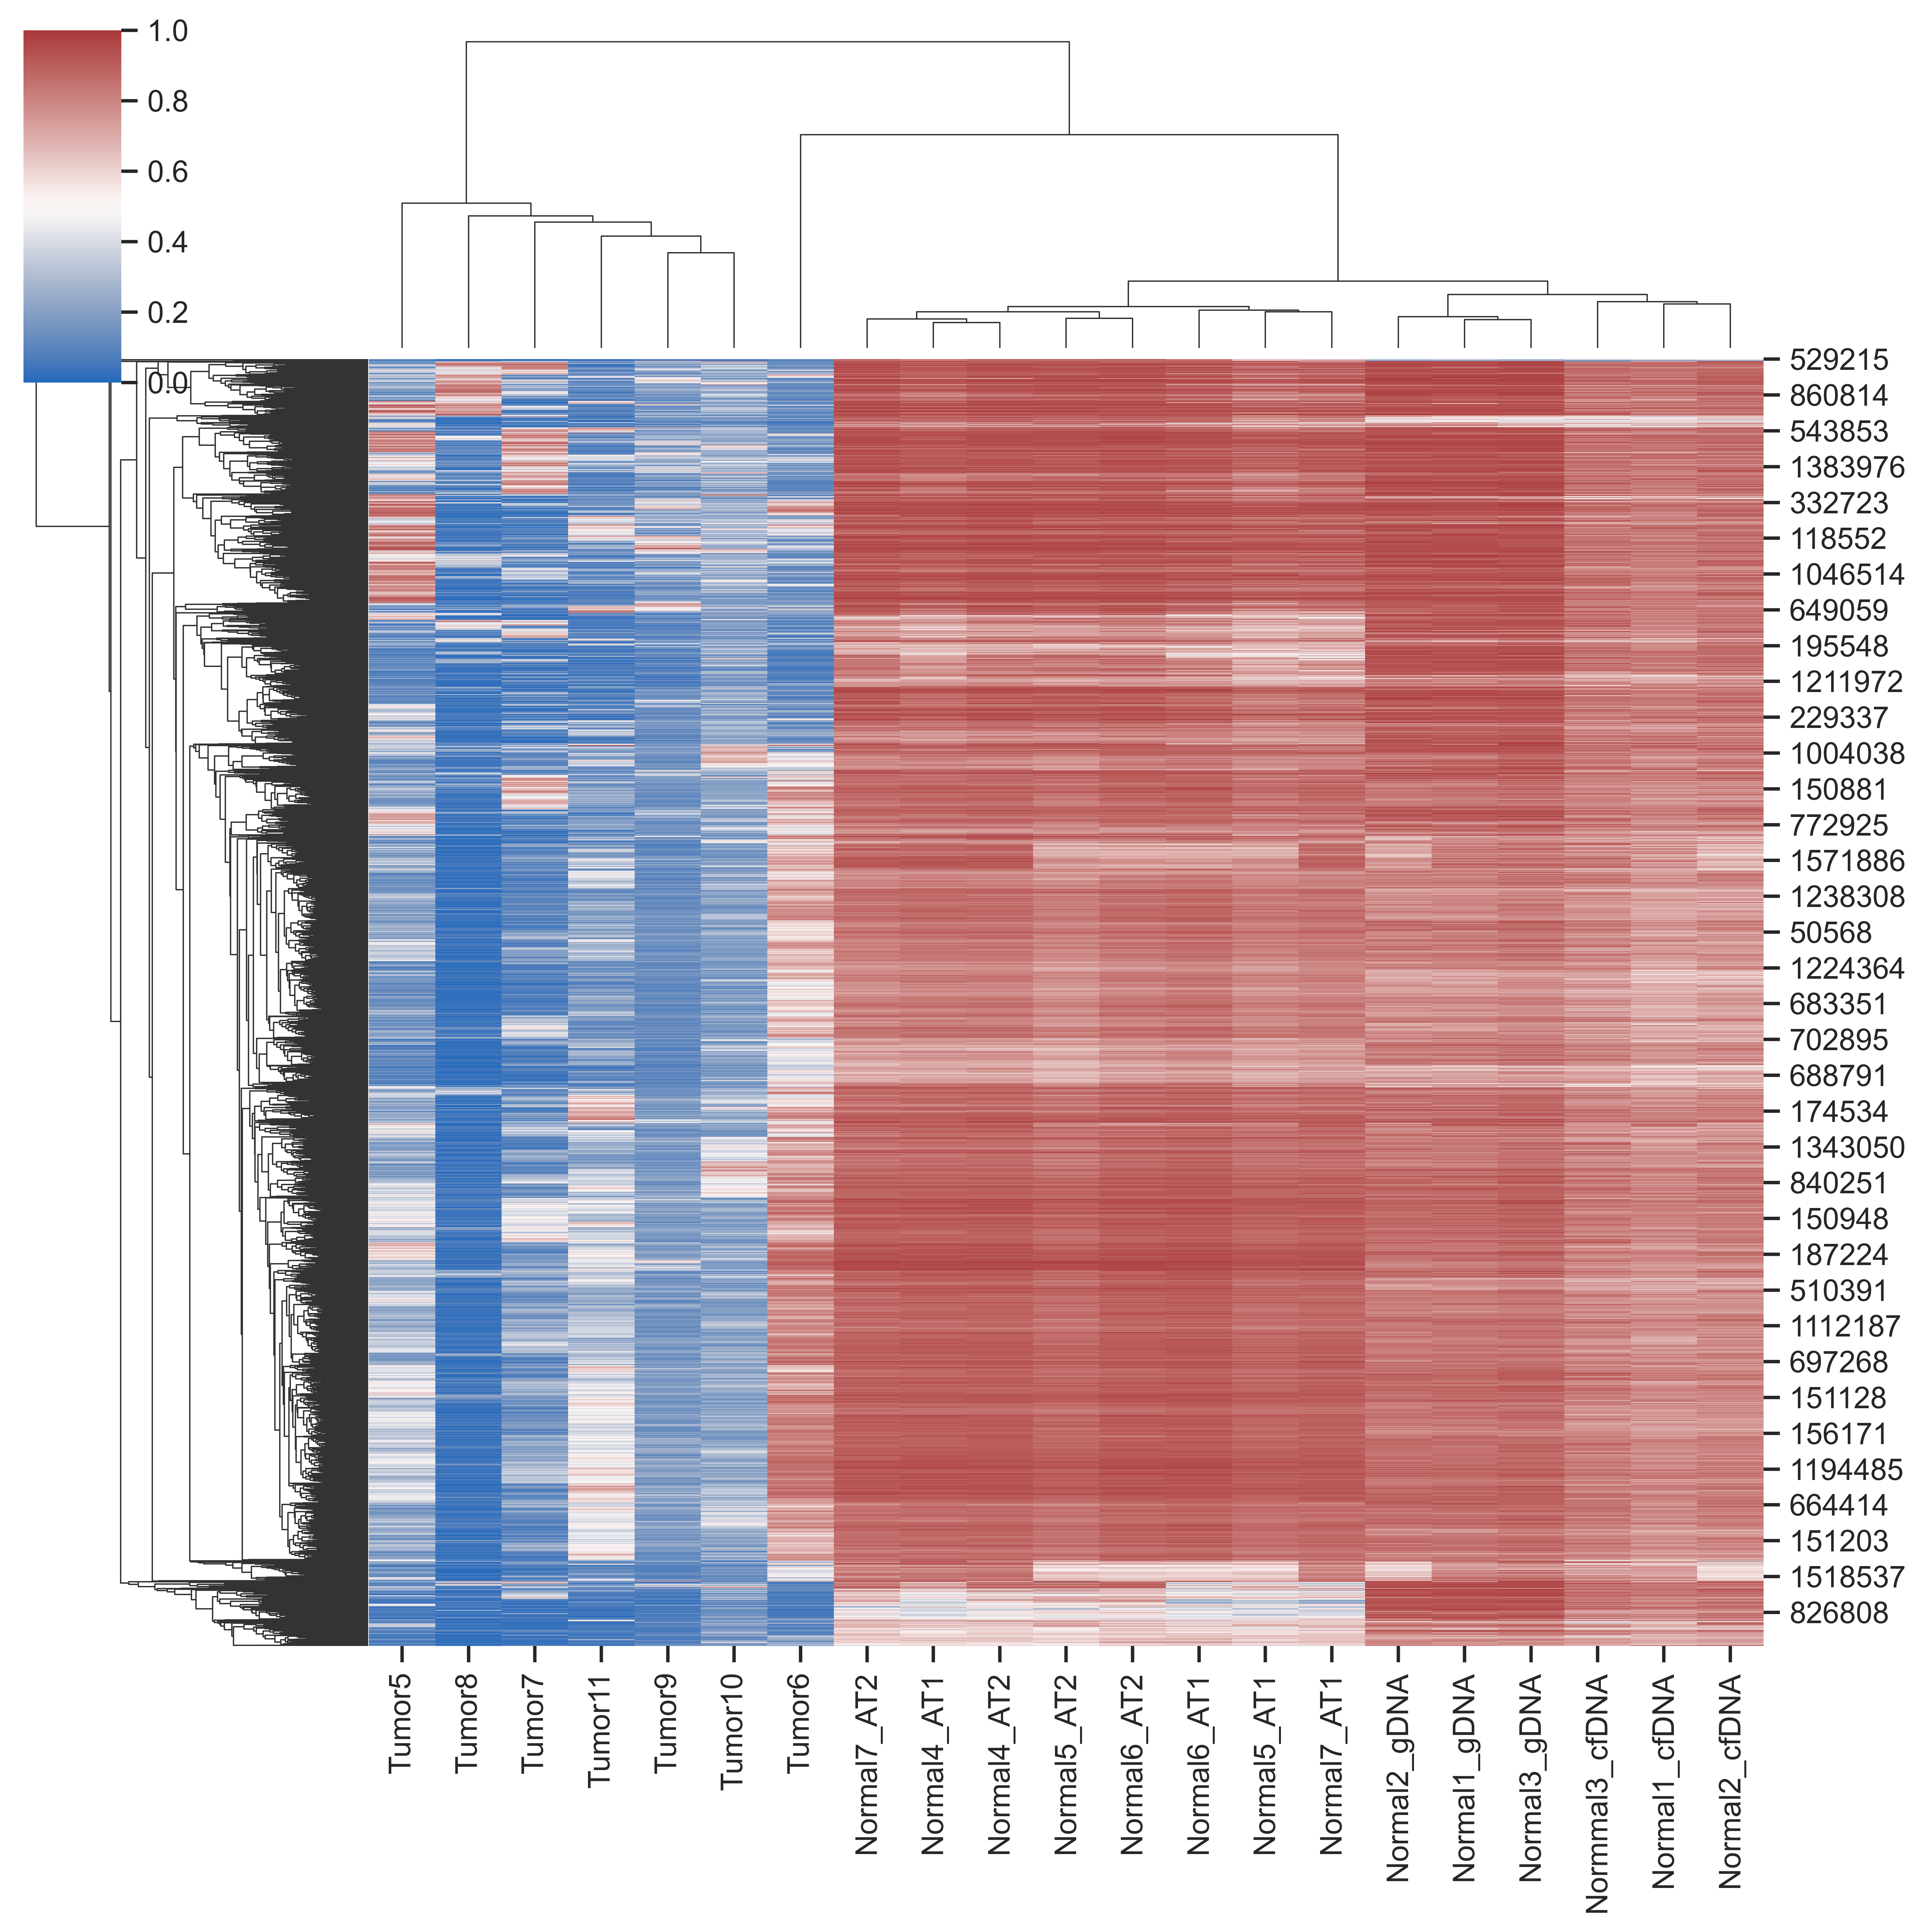

In [22]:
plt.figure(figsize=(11, 8.5))

sns.clustermap(
    beta_matrix.iloc[reg_sig_hipo.index, 5::],
    cmap = 'vlag',
    center = 0.5
)
plt.show()

/Users/dalmanza/anaconda3/envs/CdeC_Peru/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


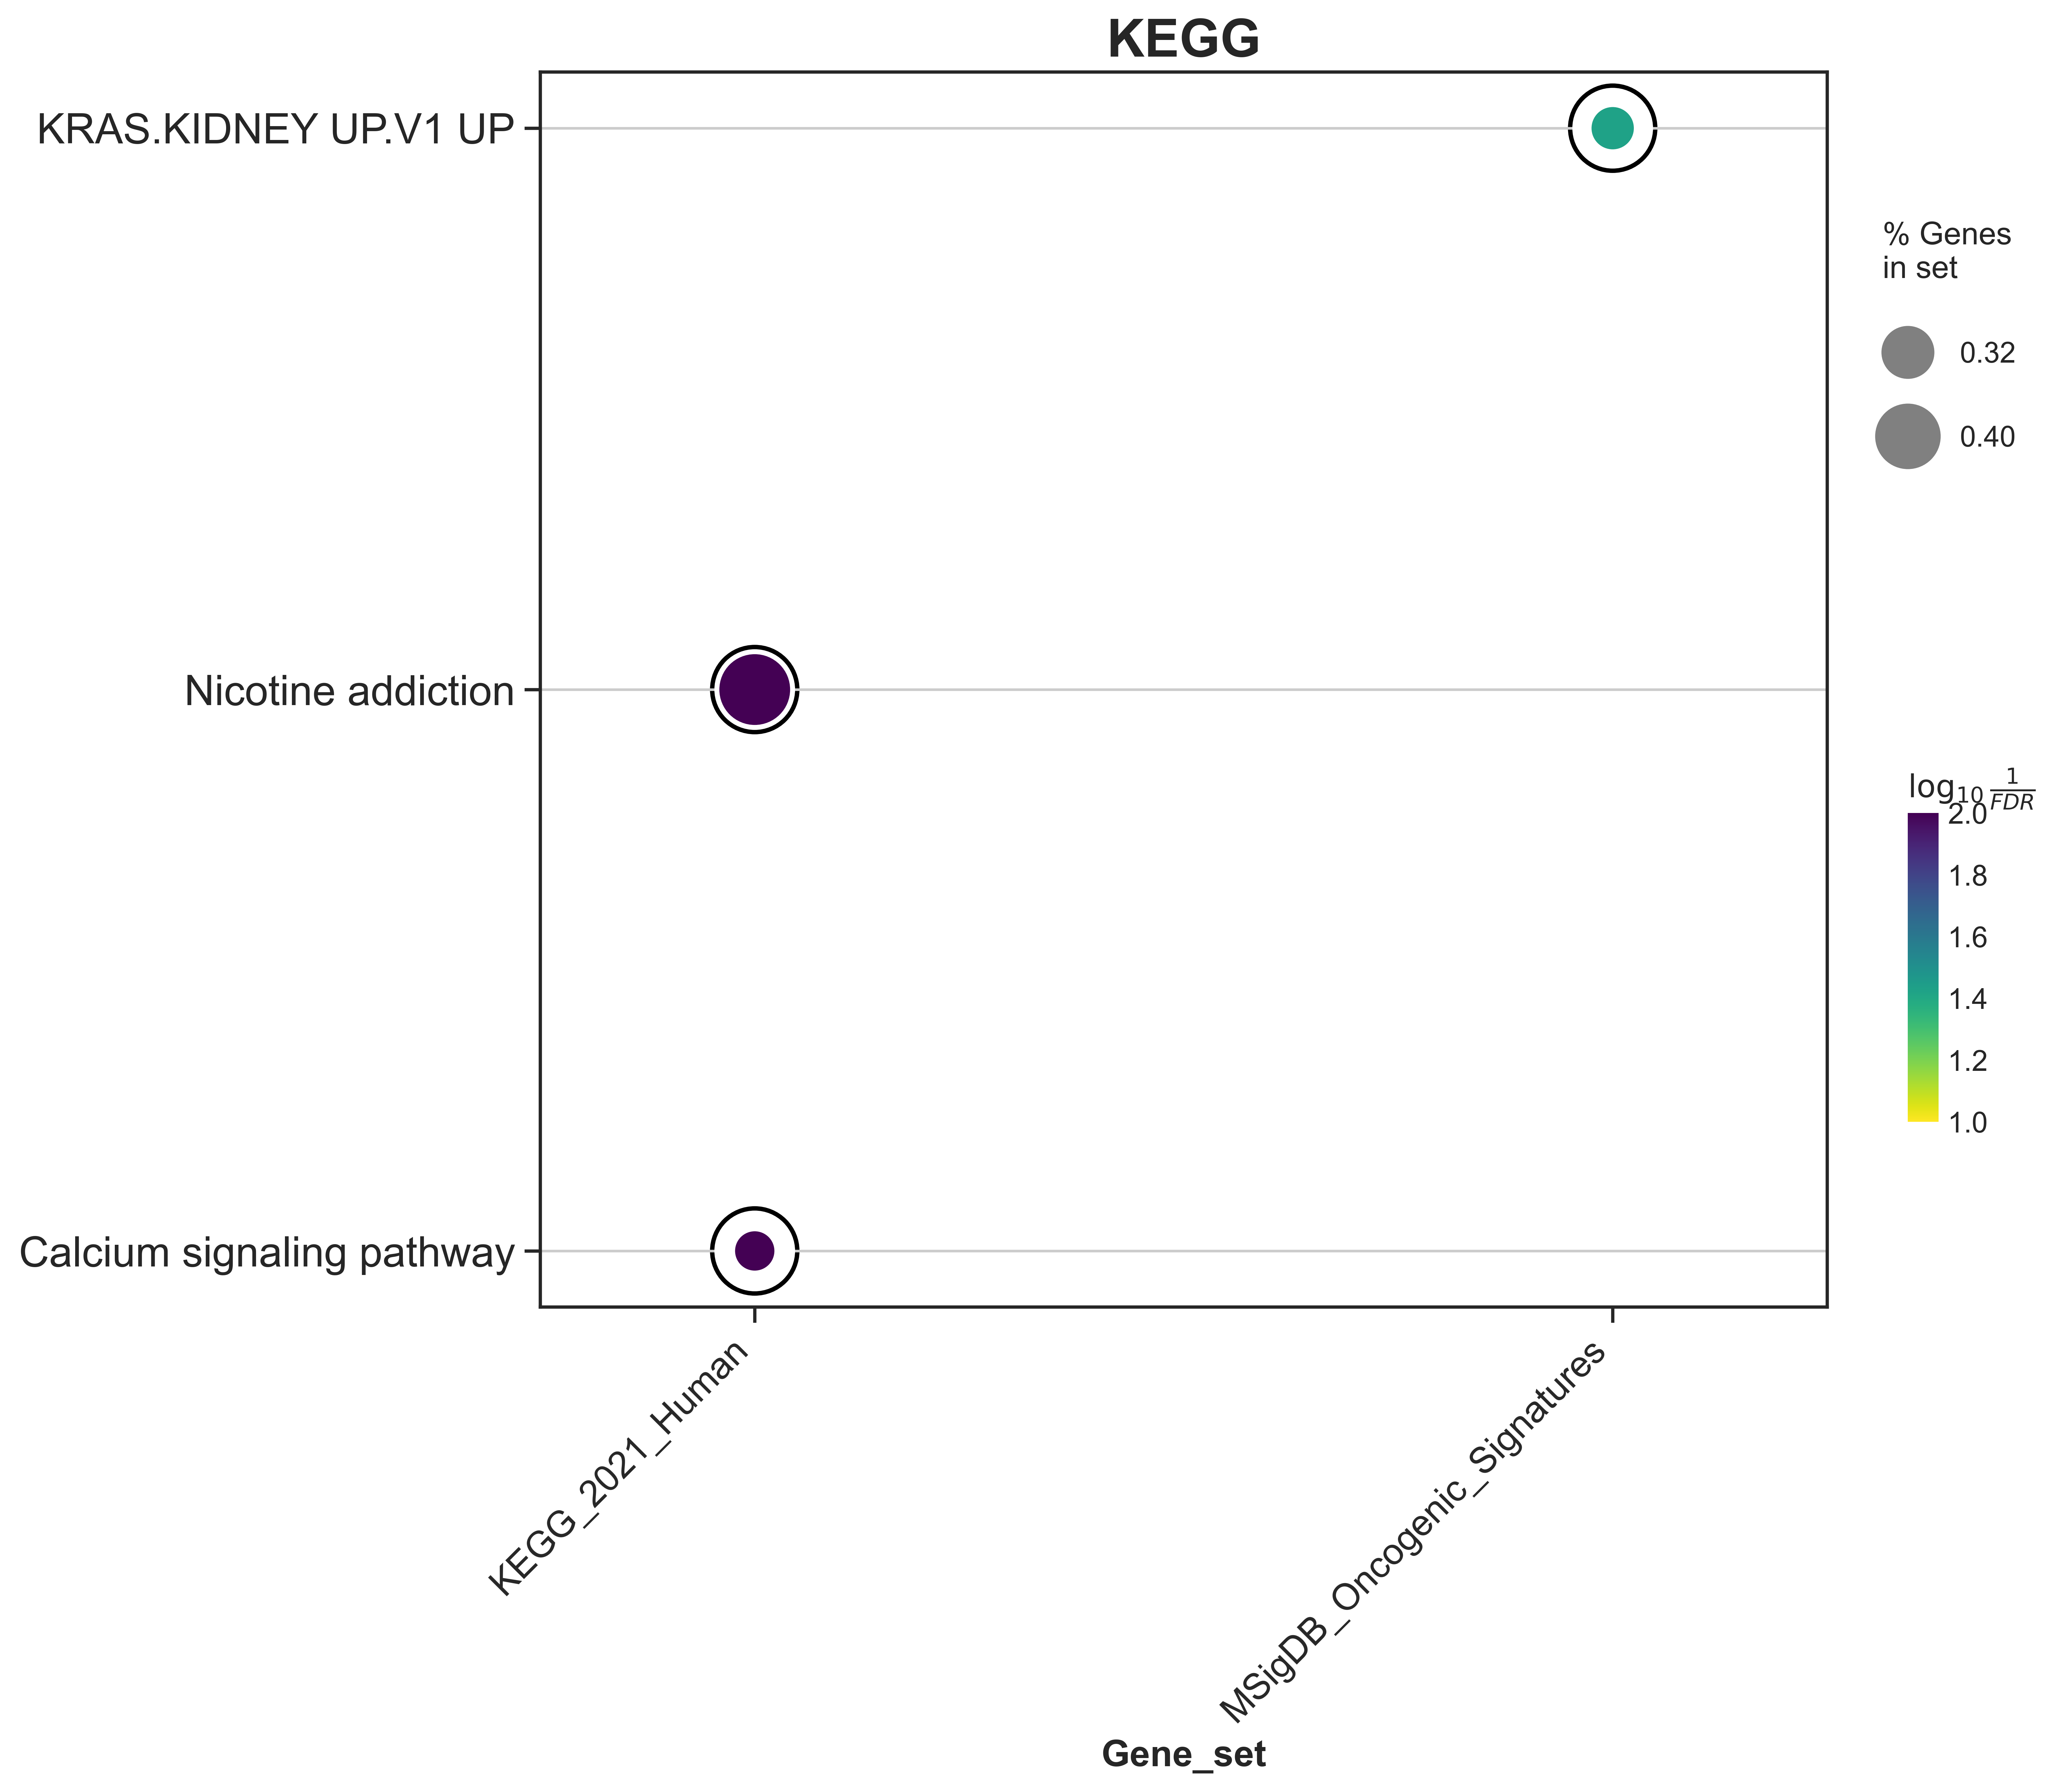

In [28]:
enr = gp.enrichr(gene_list=list(set(reg_sig_hipo['gene'])),
                 gene_sets=['GO_Biological_Process_2021', 'MSigDB_Oncogenic_Signatures','KEGG_2021_Human'],
                 organism='human',
                 outdir=None,
                )

# categorical scatterplot
ax = dotplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(11,8.5),
              title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )